In [ ]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [ ]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


#### Importing Data

In [ ]:
df = pd.read_csv('/content/unzipped_files/multimodal_train.tsv', sep='\t')

In [ ]:
df.drop(['2_way_label', '3_way_label', 'title'], axis = 1, inplace =True)

In [ ]:
df.head(10)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,0.84,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,0.99,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,0.92,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,0.95,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,0.84,2
5,CrimsonBlue90,bride and groom exchange vows after fatal shoo...,1.423681e+09,independent.ie,True,2vkbtj,https://external-preview.redd.it/FQ-J9OIPFRpqi...,NaN,7.0,6,nottheonion,0.64,0
6,happenpupe,major thermos,1.495660e+09,i.redd.it,True,6d50rl,https://preview.redd.it/l9gvkkf3jizy.jpg?width...,NaN,0.0,2,pareidolia,0.67,2
7,nyswagggggggg,rabbi meat from cloned pig could be kosher for...,1.521729e+09,timesofisrael.com,True,86byl8,https://external-preview.redd.it/KHisCPOGwz7cz...,NaN,577.0,6769,nottheonion,0.92,0
8,ApiContraption,cutouts,1.397145e+09,NaN,True,cgp0lmq,http://i.imgur.com/vbveIEd%2ejpg,22p8pc,NaN,1,psbattle_artwork,NaN,4
9,Charr-the-Chair,jesus christ converting local teens to christi...,1.534787e+09,i.redd.it,True,98vrcq,https://preview.redd.it/31aw9wjucah11.jpg?widt...,NaN,0.0,5,fakehistoryporn,0.79,2


In [ ]:
# Splitting complete Fakeddit-dataset into 10% training dataframe and 90%
# backup dataframe
# This is to work with a smaller sample size of data
df, df_backup = train_test_split(
    df,
    test_size=0.95,
    shuffle=True,
    # To maintain percentage of samples per class as given by original dataset
    stratify=df["6_way_label"]
)

#### Data visualization

In [ ]:
# Reset indexes as we are now working with a smaller sample of original dataset
df.reset_index(drop=True, inplace=True)
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,Eduardos99,kim jong uns birthday party,1.535806e+09,i.redd.it,True,9c2rs2,https://preview.redd.it/38ktah4thmj11.jpg?widt...,NaN,9.0,275,fakehistoryporn,0.98,2
1,NaN,new study finds most of earths oxygen used for...,1.531772e+09,theonion.com,True,8zefds,https://external-preview.redd.it/yAaBkPtZmHJSo...,NaN,0.0,15,theonion,0.99,1
2,Xandero-Man,yet another insanely red watermelon what are t...,1.567048e+09,i.redd.it,True,cwv4ug,https://preview.redd.it/wy4dwl210bj31.jpg?widt...,NaN,6.0,28,mildlyinteresting,0.79,0
3,sumofdifference,world war poster by british india,1.483775e+09,pbs.twimg.com,True,5mjcsa,https://external-preview.redd.it/Y0AY86pTj_TaF...,NaN,5.0,289,propagandaposters,0.99,5
4,Before_Plastic,toronto original motion picture soundtrack,1.517113e+09,i.redd.it,True,7ti2wa,https://preview.redd.it/td2qj3xgiqc01.png?widt...,NaN,6.0,22,fakealbumcovers,0.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,2shizhtzu4u,found tow mater,1.570020e+09,i.redd.it,True,dc9lmc,https://preview.redd.it/rhapighih4q31.jpg?widt...,NaN,2.0,24,mildlyinteresting,0.81,0
28196,cannedgreatness,found this super happy little guy at wendys th...,1.469981e+09,imgur.com,True,4vhoh7,https://external-preview.redd.it/tW6AKSes9hKvo...,NaN,0.0,17,pareidolia,0.77,2
28197,Barseps,year old colourized winston churchill,1.517781e+09,i.redd.it,True,7v9x07,https://preview.redd.it/84q5j7qpw6e01.jpg?widt...,NaN,32.0,1656,photoshopbattles,0.97,0
28198,tanne_sita_jallua,thats my secret im always making fun of religion,1.379601e+09,NaN,True,ccbex87,http://i.imgur.com/qd6qplG.jpg,1mowjb,NaN,3,psbattle_artwork,NaN,4


Checking for NaN values in relevant columns of DataFrame

In [ ]:
print(df['clean_title'].isnull().sum())
print(df['id'].isnull().sum())
print(df['hasImage'].isnull().sum())

# Check for how many rows the column hasImage would be False
print(df['hasImage'].value_counts())

0
0
0
hasImage
True    28200
Name: count, dtype: int64


**Plotting the 6- Way Class Distribution of dataset:**
- 0: TRUE
- 1: SATIRE
- 2: FALSE CONNECTION
- 3: IMPOSTER CONTENT
- 4: MANIPULATED CONTENT
- 5: MISLEADING CONTENT

<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

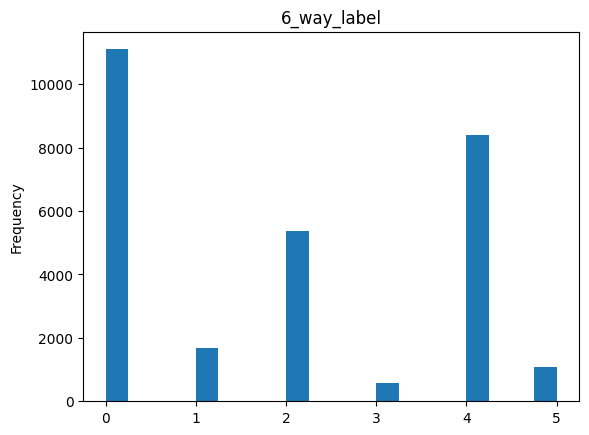

In [ ]:
from matplotlib import pyplot as plt
df['6_way_label'].plot(kind='hist', bins=20, title='6_way_label')

In [ ]:
import nest_asyncio
nest_asyncio.apply()


In [ ]:
! pip install aiofiles

In [ ]:
import os
import pandas as pd
import numpy as np
import asyncio
import aiohttp
import aiofiles
import time
from asyncio import Semaphore

# === Config ===
IMAGE_DIR = "./image"
CONCURRENT_REQUESTS = 128
RETRY_LIMIT = 5
RETRY_BACKOFF_BASE = 1
CHUNK_SIZE = 16 * 1024
TIMEOUT = aiohttp.ClientTimeout(total=30)

# === Prepare DataFrame ===
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Filter only valid image URLs
df_filtered = df[(df["hasImage"] == True) & (df["image_url"] != "") & (df["image_url"] != "nan")]

print(f"\n📊 Total in original df: {len(df)}")
print(f"✅ Filtered valid image rows: {len(df_filtered)}")

# Ensure image folder exists
os.makedirs(IMAGE_DIR, exist_ok=True)

# === Async image download setup ===
semaphore = Semaphore(CONCURRENT_REQUESTS)

async def download_image(session, row):
    image_url = row["image_url"]
    image_id = row["id"]
    path = os.path.join(IMAGE_DIR, f"{image_id}.jpg")

    if os.path.exists(path):
        return image_id, 'exists'

    async with semaphore:
        for attempt in range(1, RETRY_LIMIT + 1):
            try:
                async with session.get(image_url) as response:
                    response.raise_for_status()
                    async with aiofiles.open(path, 'wb') as f:
                        async for chunk in response.content.iter_chunked(CHUNK_SIZE):
                            await f.write(chunk)
                    return image_id, 'downloaded'
            except (aiohttp.ClientError, asyncio.TimeoutError) as e:
                if attempt == RETRY_LIMIT:
                    return image_id, 'failed'
                await asyncio.sleep(RETRY_BACKOFF_BASE * 2 ** (attempt - 1))

async def main():
    connector = aiohttp.TCPConnector(limit=CONCURRENT_REQUESTS, ttl_dns_cache=300)
    async with aiohttp.ClientSession(connector=connector, timeout=TIMEOUT) as session:
        tasks = [download_image(session, row) for _, row in df_filtered.iterrows()]
        results = []
        for count, future in enumerate(asyncio.as_completed(tasks), 1):
            image_id, status = await future
            results.append((image_id, status))
            if count % 100 == 0 or count == len(tasks):
                print(f"📦 Processed {count}/{len(tasks)} images")
        return results

# === Run the download ===
start = time.time()
results = await main()
duration = time.time() - start

# === Analyze results ===
failed_ids = [img_id for img_id, status in results if status == 'failed']
downloaded_count = sum(1 for _, s in results if s == 'downloaded')
exists_count = sum(1 for _, s in results if s == 'exists')

# === Summary ===
print(f"\n⏱️ Completed in {duration:.2f} seconds")
print(f"📥 Downloaded: {downloaded_count}")
print(f"📁 Already existed: {exists_count}")
print(f"❌ Failed: {len(failed_ids)}")
print(f"📊 Total attempted: {len(results)}")

# Remove failed rows from dataframe
df_cleaned = df[~df['id'].isin(failed_ids)].reset_index(drop=True)


# mat use kar ye niche vala

(229, 320, 3)


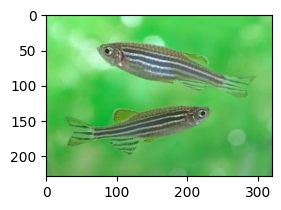

(426, 320, 3)


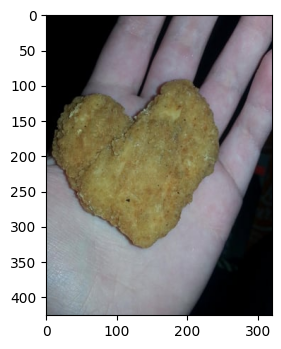

(426, 320, 3)


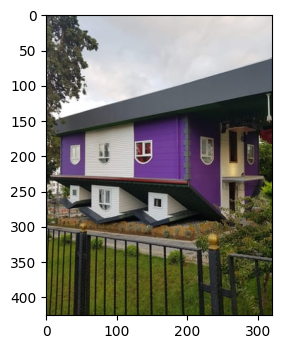

(168, 320, 3)


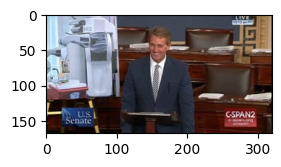

(234, 320, 3)


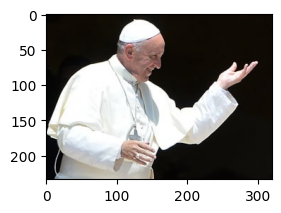

In [ ]:
# Plotting images to test download
for i in range(5):
    path = "/content/image/" + df_cleaned["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

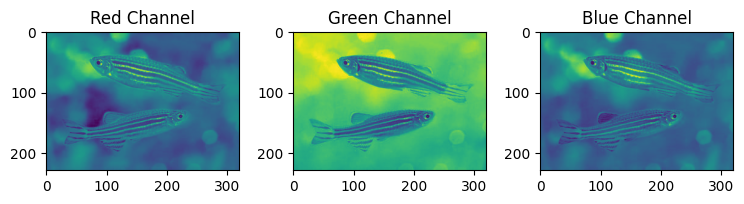

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the RGBA image
image_path = "/content/image/" + df_cleaned["id"][0] + ".jpg"
image = Image.open(image_path).convert("RGB")

# Split the image into individual channels
r, g, b = image.split()

# Plot each channel separately
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(r)
plt.title('Red Channel')

plt.subplot(1, 4, 2)
plt.imshow(g)
plt.title('Green Channel')

plt.subplot(1, 4, 3)
plt.imshow(b)
plt.title('Blue Channel')

#plt.subplot(1, 4, 4)
#plt.imshow(a)
#plt.title('Alpha Channel')

plt.tight_layout()
plt.show()

In [ ]:
import os
from PIL import Image

def validate_images(directory, df):
    corrupted_files = []
    indices_to_drop = []

    for index, row in df_cleaned.iterrows():
        image_path = os.path.join(directory, f"{row['id']}.jpg")
        try:
            with Image.open(image_path) as img:
                img.verify()  # Check for corruption without fully loading
        except Exception as e:
            corrupted_files.append(image_path)
            indices_to_drop.append(index)
            print(f"❌ Corrupt: {image_path} — {e}")

    # Drop all bad rows at once
    df_cleaned.drop(index=indices_to_drop, inplace=True)
    df_cleaned.reset_index(drop=True, inplace=True)

    return df_cleaned, corrupted_files

# Usage
IMAGE_DIR = "/content/image"
df_cleaned, corrupted_images = validate_images(IMAGE_DIR, df_cleaned)

if corrupted_images:
    print(f"🛑 Found {len(corrupted_images)} corrupted images.")
else:
    print("✅ All images are valid!")

print("✅ Final DataFrame shape:", df_cleaned.shape)


In [ ]:
# Resizing all the images to a standard (256,256, 3) using pytorch

# Define the desired size
new_size = (256, 256)

for index, row in df_cleaned.iterrows():
    image_path = "/content/image/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")

    # Resize the image using PyTorch's torchvision.transforms
    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(256, 256, 3)


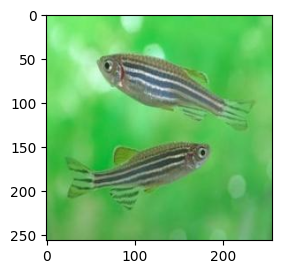

(256, 256, 3)


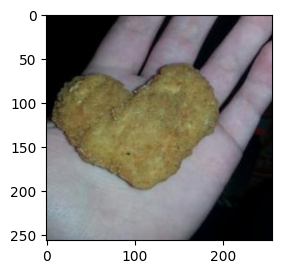

(256, 256, 3)


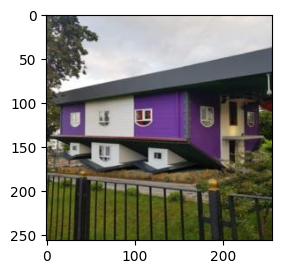

(256, 256, 3)


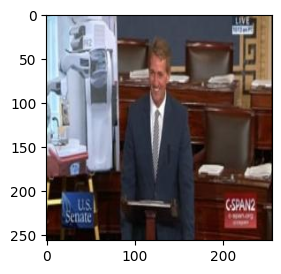

(256, 256, 3)


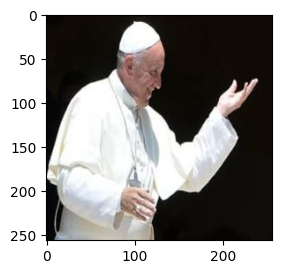

In [ ]:
# Plotting images to test resize
for i in range(5):
    path = "/content/image/" + df_cleaned["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states = True)

# Put the model in evaluation mode, which turns off dropout regularization which is used in training.
bert_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embedding(text):
    # Tokenize input text and get token IDs and attention mask
    inputs = tokenizer.encode_plus(text, add_special_tokens = True, return_tensors='pt', max_length=80, truncation=True, padding='max_length')

    return inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)

# Testing embedding
text = "This is an example Reddit submission title."
input_ids, attention_mask = get_bert_embedding(text)
print(input_ids.shape)
print(attention_mask.shape)
# print(embedding)

torch.Size([80])
torch.Size([80])


#### Loading and Processing Input Data

In [ ]:
from sklearn.model_selection import train_test_split

# Split original df into train and temp (test+val)
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df["6_way_label"])

# Then split temp into test and val equally
df_test, df_val = train_test_split(df_temp, test_size=0.5, stratify=df_temp["6_way_label"])


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.v2 as v2
from transformers import BertTokenizer

class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="6_way_label", image_id="id"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id

        # Image preprocessing
        self.img_size = 256
        self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

        self.transform_func = v2.Compose([
            v2.Resize(self.img_size),
            v2.CenterCrop(self.img_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(self.mean, self.std)
        ])

        # Load tokenizer once
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Text
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]
        img_path = "/content/image/" + self.df.at[index, self.image_id] + ".jpg"

        # Image loading and transform
        try:
            image = Image.open(img_path).convert("RGB")
            image = self.transform_func(image)
        except Exception as e:
            print(f"[Image Load Fail] {img_path}: {e}")
            image = torch.zeros(3, self.img_size, self.img_size)

        # Tokenization
        encoded = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long),
            'image': image
        }


In [ ]:
train_dataset = FakedditDataset(df_train)
test_dataset = FakedditDataset(df_test)
val_dataset = FakedditDataset(df_val)

In [ ]:
import torch
from torch.utils.data import DataLoader

# Set batch size and number of workers (adjust for your GPU)
BATCH_SIZE = 3
NUM_WORKERS = 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Print loader info
print(f"Number of batches in train_loader: {len(train_loader)}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load one batch from train_loader
batch = next(iter(train_loader))

# Move batch tensors to device
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
label = batch['label'].to(device)
img = batch['image'].to(device)

# Print tensor shapes
print("\n✅ Batch tensor shapes:")
print(f"Input IDs      : {input_ids.shape}")
print(f"Attention Mask : {attention_mask.shape}")
print(f"Labels         : {label.shape}")
print(f"Images         : {img.shape}")


Number of batches in train_loader: 7520
Using device: cuda
[Image Load Fail] /content/image/cewj0dl.jpg: [Errno 2] No such file or directory: '/content/image/cewj0dl.jpg'[Image Load Fail] /content/image/9h4x7q.jpg: [Errno 2] No such file or directory: '/content/image/9h4x7q.jpg'

[Image Load Fail] /content/image/cwacva.jpg: [Errno 2] No such file or directory: '/content/image/cwacva.jpg'[Image Load Fail] /content/image/dt7m8q2.jpg: [Errno 2] No such file or directory: '/content/image/dt7m8q2.jpg'

[Image Load Fail] /content/image/ccvs6x.jpg: [Errno 2] No such file or directory: '/content/image/ccvs6x.jpg'
[Image Load Fail] /content/image/beew8q.jpg: [Errno 2] No such file or directory: '/content/image/beew8q.jpg'
[Image Load Fail] /content/image/46s53h.jpg: [Errno 2] No such file or directory: '/content/image/46s53h.jpg'[Image Load Fail] /content/image/1u65ip.jpg: [Errno 2] No such file or directory: '/content/image/1u65ip.jpg'
[Image Load Fail] /content/image/8u3sln.jpg: [Errno 2] No 

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.3):
        super(MultimodalClassifier, self).__init__()
        self.num_classes = num_classes

        # Image CNN branch
        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (32, 128, 128)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (64, 64, 64)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# (128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (128, 32, 32)

            nn.AdaptiveAvgPool2d((1, 1))                           # (128, 1, 1)
        )

        self.image_fc = nn.Sequential(
            nn.Linear(128, num_classes),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(dropout_rate)

        # BERT text branch
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.fc_text = nn.Linear(self.text_model.config.hidden_size, num_classes)

    def forward(self, image, input_ids, attention_mask):
        # Image branch
        x_img = self.image_conv(image)              # (batch, 128, 1, 1)
        x_img = x_img.view(x_img.size(0), -1)       # (batch, 128)
        x_img = self.image_fc(x_img)                 # (batch, num_classes)
        x_img = self.dropout(x_img)

        # Text branch
        outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        x_text = self.fc_text(pooled_output)                # (batch, num_classes)
        x_text = self.dropout(x_text)

        # Fusion: element-wise max
        x = torch.max(x_img, x_text)

        return x


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultimodalClassifier(num_classes=6)
model= model.to(device)

#### Training and Evaluating the Model

In [ ]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints messages when improvement occurs or counter increases.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.verbose:
                print(f"Initial best loss set to {val_loss:.4f}")
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                self.early_stop = True
        else:
            if self.verbose and self.counter > 0:
                print(f"Validation loss improved from {self.best_loss:.4f} to {val_loss:.4f}. Resetting counter.")
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
labels = df_train['6_way_label'].to_numpy()
#type(labels)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
# 'labels' should be a list or numpy array of all dataset labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and LR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True, min_lr=1e-6
)

num_epochs = 20

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for input_ids, attention_mask, label, img in train_loader:
            # Move data to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(img, input_ids, attention_mask)
            loss = criterion(outputs, label)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_preds = 0

        with torch.no_grad():
            for input_ids, attention_mask, label, img in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)

                outputs = model(img, input_ids, attention_mask)
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                preds = outputs.argmax(dim=1)
                correct_preds += torch.sum(preds == label)

        avg_train_loss = running_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_preds.double() / len(val_loader.dataset)

        scheduler.step(avg_val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

        # Check early stopping condition
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    # Optionally save the best model
    # torch.save(model.state_dict(), './model_best.pth')

# Example call:
# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Evaluation loop for model:

In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_losses = []
    correct_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, label, img in test_loader:
            # Move tensors to device once
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
            img = img.to(device, non_blocking=True)

            # Forward pass
            outputs = model(img, input_ids, attention_mask)

            # Calculate loss and accumulate
            loss = criterion(outputs, label)
            val_losses.append(loss.item())

            # Predictions and accuracy count
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == label).sum().item()

            # Collect predictions and labels on CPU to save GPU memory
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    accuracy = 100.0 * correct_preds / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nEvaluation Results:")
    print(f"Average Loss: {avg_val_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")


In [ ]:
#train_model(model, train_loader, criterion, optimizer, num_epochs)
print("\n")
#evaluate_model(model, test_loader, criterion)

#### Building Improved Model

`BERTResNetClassifier` class processes post title and image data using `Bert-Base model` for processing text data and a `ResNet model` for processing image data, and is derived of `nn.Module` model super class from torch.nn module.

Sample Reference upon which I based my model architecture:
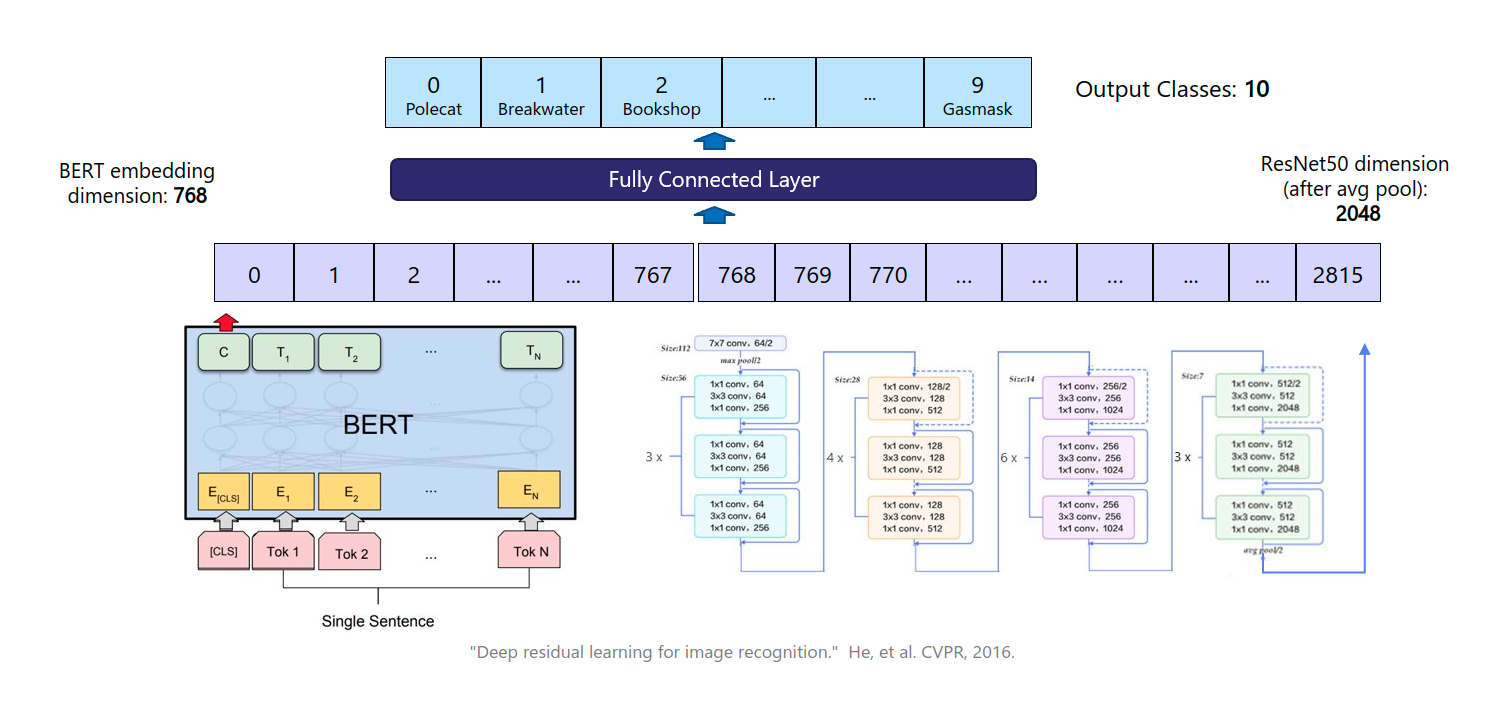

##### Why switch to ResNets vs shallow CNNs?
*   Residual Network (ResNet) are a Convolutional Neural Network (CNN) architecture that overcomes the “vanishing gradient” problem using shortcut connections
*   ResNets have shown better accuracy than shallow CNNs when training on smaller image datasets.
*   Compared to other CNN models, ResNet-50 has a smaller loss value and converges faster.
*   ResNet50 achieves better parameter efficiency due to its bottleneck architecture, where 1x1 convolutions are used to reduce and then restore the dimensionality of the data

---

*  I continued to use the `torch.max()` function to merge the features from the text and image branches of multimodal model.
*   **Activation Function**: `softmax()`
  - Applied alongside CrossEntropyLoss loss function




In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from transformers import BertModel

class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_prob=0.3):
        super().__init__()

        # Pretrained ResNet50 backbone, remove final FC
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.image_model.fc = nn.Identity()  # Output features: 2048

        # Dimensionality reduction for image features
        self.fc_image = nn.Linear(2048, 512)

        # Pretrained BERT model
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Dimensionality reduction for text CLS embedding
        self.fc_text = nn.Linear(self.text_model.config.hidden_size, 512)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)

        # Fusion via element-wise max + final classification
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, image, text_input_ids, text_attention_mask):
        # Extract image features
        img_features = self.image_model(image)           # shape: (batch, 2048)
        img_features = self.dropout(img_features)
        img_features = self.fc_image(img_features)       # shape: (batch, 512)

        # Extract text features from CLS token
        text_outputs = self.text_model(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            return_dict=True
        )
        cls_embedding = text_outputs.last_hidden_state[:, 0, :]  # shape: (batch, 768)
        cls_embedding = self.dropout(cls_embedding)
        text_features = self.fc_text(cls_embedding)      # shape: (batch, 512)

        # Fusion: element-wise max of image and text features
        fused = torch.max(img_features, text_features)  # shape: (batch, 512)

        # Classification layer
        logits = self.classifier(fused)                   # shape: (batch, num_classes)
        return logits


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define model ===
# Example: A simple model that combines BERT and ResNet50 features
from transformers import BertModel
import torchvision.models as models

class MultiModalModel(nn.Module):
    def __init__(self, num_labels):
        super(MultiModalModel, self).__init__()

        # BERT for text
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(self.bert.config.hidden_size, 256)

        # ResNet for image
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False  # Freeze
        resnet.fc = nn.Identity()  # Remove last layer
        self.resnet = resnet
        self.image_fc = nn.Linear(2048, 256)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, image):
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_feat = self.text_fc(text_feat)

        img_feat = self.resnet(image)
        img_feat = self.image_fc(img_feat)

        combined = torch.cat((text_feat, img_feat), dim=1)
        output = self.classifier(combined)
        return output

# === Instantiate dataset, dataloaders ===
batch_size = 16
num_epochs = 5
num_classes = 6  # For 6-way classification

train_dataset = FakedditDataset(df_train)
val_dataset = FakedditDataset(df_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# === Initialize model, loss, optimizer, scheduler ===
model = MultiModalModel(num_labels=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# === Training function ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # === Training ===
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            imgs = batch['image'].to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        acc = correct / total
        print(f"✅ Train Loss: {train_loss / len(train_loader):.4f} | Accuracy: {acc:.4f}")

        # === Validation ===
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                imgs = batch['image'].to(device)

                outputs = model(input_ids, attention_mask, imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        print(f"🧪 Val Loss: {val_loss / len(val_loader):.4f} | Accuracy: {acc:.4f}")

# === Train ===
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# === Save model ===
torch.save(model.state_dict(), "multimodal_model.pth")
print("✅ Model saved!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/5
------------------------------


Training: 100%|██████████| 940/940 [06:23<00:00,  2.45it/s]


✅ Train Loss: 0.9416 | Accuracy: 0.6634


Validation: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


🧪 Val Loss: 0.7287 | Accuracy: 0.7468

Epoch 2/5
------------------------------


Training: 100%|██████████| 940/940 [06:27<00:00,  2.43it/s]


✅ Train Loss: 0.5776 | Accuracy: 0.8067


Validation: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


🧪 Val Loss: 0.7064 | Accuracy: 0.7537

Epoch 3/5
------------------------------


Training: 100%|██████████| 940/940 [06:25<00:00,  2.44it/s]


✅ Train Loss: 0.3412 | Accuracy: 0.8924


Validation: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


🧪 Val Loss: 0.7567 | Accuracy: 0.7590

Epoch 4/5
------------------------------


Training: 100%|██████████| 940/940 [06:26<00:00,  2.43it/s]


✅ Train Loss: 0.2925 | Accuracy: 0.9091


Validation: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


🧪 Val Loss: 0.7904 | Accuracy: 0.7612

Epoch 5/5
------------------------------


Training: 100%|██████████| 940/940 [06:26<00:00,  2.43it/s]


✅ Train Loss: 0.2567 | Accuracy: 0.9231


Validation: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


🧪 Val Loss: 0.7989 | Accuracy: 0.7585
✅ Model saved!


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # Training Loop
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"✅ Epoch {epoch+1}: Train Loss={total_loss:.4f}, Accuracy={train_acc:.2f}%")

        # Validation Loop
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        print(f"🔍 Epoch {epoch+1}: Val Loss={val_loss:.4f}, Accuracy={val_acc:.2f}%")

        scheduler.step()

    # Save the final model
    torch.save(model.state_dict(), "/content/drive/MyDrive/multimodal_model_finetuned.pth")
    print("✅ Model fine-tuned and saved to Drive.")
